# Import Necessary Library

In [1]:
import time
from haversine_script import *
import numpy as np
import tensorflow as tf
import random
import pandas as p
import math
import matplotlib.pyplot as plt
import os
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation,BatchNormalization
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping
from keras import regularizers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

Using TensorFlow backend.


# Dataset Preprocessing Functions

In [2]:
def get_exponential_distance(x,minimum,a=60):
	positive_x= x-minimum
	numerator = np.exp(positive_x.div(a))
	denominator = np.exp(-minimum/a)
	exponential_x = numerator/denominator
	exponential_x = exponential_x * 1000  #facilitating calculations
	final_x = exponential_x
	return final_x

In [3]:
def get_powed_distance(x,minimum,b=1.1):
	positive_x= x-minimum
	numerator = positive_x.pow(b)
	denominator = (-minimum)**(b)
	powed_x = numerator/denominator
	final_x = powed_x
	return final_x

# Python Random Seeding for experiment reproducibility

In [4]:
os.environ['PYTHONHASHSEED'] = "42"
np.random.seed(42)
tf.set_random_seed(42)
random.seed(42)

In [6]:
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1) 
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Loading Dataset

In [7]:
# reading the data
file = p.read_csv('lorawan_antwerp_2019_dataset.csv')
columns = file.columns
# x = file[columns[0:68]]
# y = file[columns[71:]]
x = file[columns[0:72]]
x = x.join(file[columns[73]])
y = file[columns[72:]]


Dataset Preprocessing

In [8]:
x = x.replace(-200,200)
minimum = x.min().min() - 1
x = x.replace(200,minimum)
print('minimum')
print(minimum)

minimum
-128.0


RSSI Data representation using Powed Function


In [9]:
final_x = get_powed_distance(x,minimum)

In [10]:
random_state = 42
x_train, x_test_val, y_train, y_test_val = train_test_split(final_x.values, y.values, test_size=0.3, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=random_state)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(91300, 73)
(19564, 73)
(19565, 73)


In [11]:
n_of_features = x_train.shape[1]

scaler = preprocessing.MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


scaler_y = preprocessing.MinMaxScaler().fit(y_train)
y_train = scaler_y.transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)


# Network HyperParameters

In [12]:
dropout = 0.15
l2 = 0.00
lr = 0.0005
epochs = 300
batch_size= 512
patience = 300

# Define the MLP Network

In [13]:
model = Sequential()
#model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(dropout, seed=random_state))
#model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(dropout, seed=random_state))
#model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(dropout, seed=random_state))
#model.add(Dense(units=256, kernel_regularizer=regularizers.l2(l2)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(dropout))
model.add(Dense(units=2))
model.compile(loss='mean_absolute_error',optimizer=Adam(lr=lr))

W1125 16:14:29.141091 27220 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1125 16:14:29.163065 27220 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [14]:
cb =[EarlyStopping(monitor='val_loss', patience=patience, verbose =1, restore_best_weights=True)]
history = model.fit(x_train, y_train,validation_data=(x_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1, callbacks= cb)


W1125 16:14:33.078069 27220 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1125 16:14:33.080064 27220 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1125 16:14:33.180794 27220 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1125 16:14:33.617626 27220 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\b

Train on 91300 samples, validate on 19564 samples
Epoch 1/300
91300/91300 [==============================] - 3s 34us/step - loss: 0.1933 - val_loss: 0.1052
Epoch 2/300
91300/91300 [==============================] - 2s 24us/step - loss: 0.0726 - val_loss: 0.0725
Epoch 3/300
91300/91300 [==============================] - ETA: 0s - loss: 0.059 - 2s 26us/step - loss: 0.0594 - val_loss: 0.0613
Epoch 4/300
91300/91300 [==============================] - 2s 25us/step - loss: 0.0530 - val_loss: 0.0536
Epoch 5/300
91300/91300 [==============================] - 2s 24us/step - loss: 0.0487 - val_loss: 0.0482
Epoch 6/300
91300/91300 [==============================] - 2s 25us/step - loss: 0.0439 - val_loss: 0.0458
Epoch 7/300
91300/91300 [==============================] - 2s 22us/step - loss: 0.0420 - val_loss: 0.0380
Epoch 8/300
91300/91300 [==============================] - 2s 22us/step - loss: 0.0399 - val_loss: 0.0365
Epoch 9/300
91300/91300 [==============================] - 2s 22us/step - loss

Epoch 77/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0220 - val_loss: 0.0211
Epoch 78/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0217 - val_loss: 0.0209
Epoch 79/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0220 - val_loss: 0.0213
Epoch 80/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0216 - val_loss: 0.0264
Epoch 81/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0217 - val_loss: 0.0208
Epoch 82/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0215 - val_loss: 0.0240
Epoch 83/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0218 - val_loss: 0.0248
Epoch 84/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0214 - val_loss: 0.0218
Epoch 85/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0217 - val_loss: 0.0249
Epoch 86/300
91300/91300 [===========

91300/91300 [==============================] - 4s 39us/step - loss: 0.0199 - val_loss: 0.0194
Epoch 154/300
91300/91300 [==============================] - 3s 36us/step - loss: 0.0196 - val_loss: 0.0195
Epoch 155/300
91300/91300 [==============================] - 4s 41us/step - loss: 0.0196 - val_loss: 0.0197
Epoch 156/300
91300/91300 [==============================] - 2s 27us/step - loss: 0.0195 - val_loss: 0.0214
Epoch 157/300
91300/91300 [==============================] - 2s 25us/step - loss: 0.0196 - val_loss: 0.0205
Epoch 158/300
91300/91300 [==============================] - 3s 29us/step - loss: 0.0194 - val_loss: 0.0220
Epoch 159/300
91300/91300 [==============================] - 2s 26us/step - loss: 0.0193 - val_loss: 0.0200
Epoch 160/300
91300/91300 [==============================] - 2s 22us/step - loss: 0.0194 - val_loss: 0.0215
Epoch 161/300
91300/91300 [==============================] - 2s 26us/step - loss: 0.0192 - val_loss: 0.0185
Epoch 162/300
91300/91300 [===============

Epoch 229/300
91300/91300 [==============================] - 2s 22us/step - loss: 0.0185 - val_loss: 0.0190
Epoch 230/300
91300/91300 [==============================] - 2s 21us/step - loss: 0.0184 - val_loss: 0.0183
Epoch 231/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0184 - val_loss: 0.0187
Epoch 232/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0185 - val_loss: 0.0186
Epoch 233/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0188 - val_loss: 0.0203
Epoch 234/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0186 - val_loss: 0.0224
Epoch 235/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0181 - val_loss: 0.0218
Epoch 236/300
91300/91300 [==============================] - 2s 21us/step - loss: 0.0186 - val_loss: 0.0179
Epoch 237/300
91300/91300 [==============================] - 2s 20us/step - loss: 0.0184 - val_loss: 0.0187
Epoch 238/300
91300/91300 [=

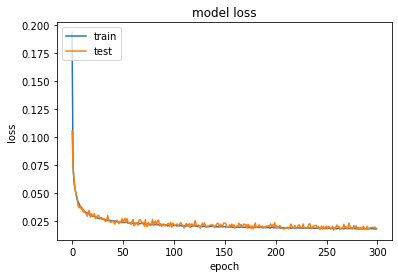

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('training_curves_paper.png')
plt.show()

# Testing

In [16]:
y_predict = model.predict(x_test, batch_size=batch_size) 
y_predict_in_val = model.predict(x_val, batch_size=batch_size)
y_predict_in_train = model.predict(x_train, batch_size=batch_size)


Revert the Representation from normalize to lat-long coordinates

In [17]:
y_predict = scaler_y.inverse_transform(y_predict)
y_predict_in_train = scaler_y.inverse_transform(y_predict_in_train)
y_predict_in_val = scaler_y.inverse_transform(y_predict_in_val)
y_train = scaler_y.inverse_transform(y_train)
y_val = scaler_y.inverse_transform(y_val)
y_test = scaler_y.inverse_transform(y_test)

Calculate Haversine Error

In [18]:
print("Train set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'mean')))
print("Train set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'median')))
print("Train set75th perc error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'percentile',75)))
print("Val set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'mean')))
print("Val set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'median')))
print("Val set 75th perc.  error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'percentile',75)))
print("Test set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'mean')))
print("Test set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'median')))
print("Test set  75th perc. error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'percentile',75)))


Train set mean error: 176.70
Train set median error: 87.29
Train set75th perc error: 196.33
Val set mean error: 189.67
Val set median error: 93.53
Val set 75th perc.  error: 222.85
Test set mean error: 190.88
Test set median error: 92.68
Test set  75th perc. error: 219.55


In [19]:
test_error_list = calculate_pairwise_error_list(y_predict,y_test)
p.DataFrame(test_error_list).to_csv("mlp_test_error_list.csv")
print("Experiment completed!!!")

Experiment completed!!!


In [20]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("baseline_paper.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("baseline_paper.h5")